In [ ]:
from google.colab import drive
drive.mount('/content/drive')
# path for google drive
path = '/content/drive/My Drive/ECSE415/FinalProject/'
frame_path = '/content/drive/My Drive/ECSE415/FinalProject/frames/'
positive_path = '/content/drive/My Drive/ECSE415/FinalProject/positive/'
negative_path = '/content/drive/My Drive/ECSE415/FinalProject/negative/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# install dependencies: 
!pip install pyyaml==5.1
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

1.7.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# install detectron2: (Colab has CUDA 10.1 + torch 1.7)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.7")
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.7/index.html


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from skimage.feature import hog
import csv

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [ ]:
def load_images(image_path):
  files = os.listdir(frame_path) 
  files_name = [file_name for file_name in files if file_name.endswith('.jpg')]
  files_name.sort()
  frames = []

  #read the first 100 images
  for i, file_name in enumerate(files_name):
    frame = cv2.imread(image_path + file_name)
    frames.append(frame)

  frames = np.array(frames)
  return frames

In [ ]:
cfg = get_cfg()
# add project-specific config (e.g., TensorMask) here if you're not running a model in detectron2's core library
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # set threshold for this model
# Find a model from detectron2's model zoo. You can use the https://dl.fbaipublicfiles... url as well
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
predictor = DefaultPredictor(cfg)

In [ ]:
# crop positive samples
def crop_objects(img, outputs, path, image_index, writer):
  classes = outputs["instances"].pred_classes
  boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
  #create dictionary to hold count of objects for image name
  index = -1
  count = 0
  for class_index in classes:
    # get count of class for part of image name
    # class_index = int(classes[i])
    index+=1
    if class_index == 0:
      # get box coords
      box = boxes[index]
      # print(box)
      xmin, ymin, xmax, ymax = box
      # crop detection from image (take an additional 5 pixels around all edges)
      cropped_img = img[int(ymin):int(ymax), int(xmin):int(xmax)]
      # construct image name and join it to path for saving crop properly
      img_name = 'Image' + str(image_index+1) + '_' + 'person' + '_' + str(count) + '.jpg'
      img_path = os.path.join(path, img_name)
      # save image
      cv2.imwrite(img_path, cropped_img)
      count+=1
    else:
      continue
  writer.writerow([image_index+1, count])
  return writer

In [ ]:
# crop negative samples randomly
def crop_random(img, path, image_index):
  count = 0;
  for n in range(100, 350, 65):
    for m in range (100, 500, 65):
      cropped_img = img[n-50:n+50, m-25:m+25]
      img_name = 'Image' + str(image_index+1) + '_' + 'negative' + '_' + str(count) + '.jpg'
      img_path = os.path.join(path, img_name)
      # save image
      cv2.imwrite(img_path, cropped_img)
      count+=1

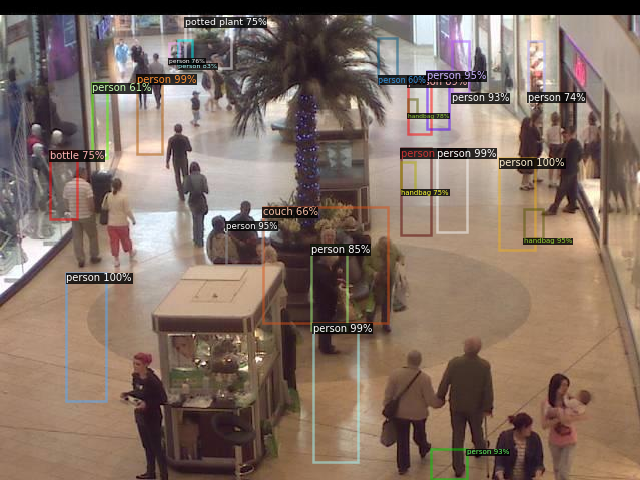

In [ ]:
seq_images = load_images(frame_path)
cfile = open(path + 'detectron_count.csv', 'w+', newline='')
writer = csv.writer(cfile)
writer.writerow(["id", "Count"])
for j in range(50, 100):
  try:
    outputs = predictor(seq_images[j])
    writer = crop_objects(seq_images[j], outputs, positive_path, j, writer)
  except Exception as e:
    print(str(e))

for j in range(1850, 2000):
  outputs = predictor(seq_images[j])
  writer = crop_objects(seq_images[j], outputs, positive_path, j, writer)
cfile.close()

v = Visualizer(seq_images[0][:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
for p in range(10, 20):
  img = seq_images[p]
  crop_random(img, negative_path, p)